# ISIC 2024 - Skin Cancer Detection: Pytorch Model w/ Image + Metadata (5 Folds)

Inspired by [motono0223](https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-eva02/notebook#Run-Training) 

Idea:
* Use 1:20 benign vs malignant training data
* Feature engineer and append snippet of data to images
* Data augment images for diversity
* Train Swin Transformer and simple PyTorch model
* Save model base on better validation AUROC

Notebooks:
* Training notebook (current)
* [Inference notebook](https://www.kaggle.com/code/qiaoyingzhang/isic-2024-pytorch-inference-swin/notebook)

# Import Libraries

In [2]:
import os
import gc
import cv2
import copy
import time
import random
import glob
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

# For Image Modelsipip 
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Initialize Environment & Configuration

In [3]:
CONFIG = {
    "seed": 2024,
    "epochs": 50,
    "img_size": 224,
    "model_name": 'swin_large_patch4_window7_224',
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-10,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 1,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

# Set seed for reproducibility
def seed_everything(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CONFIG['seed'])

In [4]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
HDF_FILE = f"{ROOT_DIR}/train-image.hdf5"

In [5]:
MV_DIR = "/kaggle/input/skin-cancer-malignant-vs-benign"
TRAIN_B_DIR = f"{MV_DIR}/train/benign"
TRAIN_M_DIR = f"{MV_DIR}/train/malignant"

VALID_B_DIR = f"{MV_DIR}/test/benign"
VALID_M_DIR = f"{MV_DIR}/test/malignant"

In [6]:
HAM_DIR = "/kaggle/input/ham10000subset"
HAM_B_DIR = f"{MV_DIR}/train/benign"
HAM_M_DIR = f"{MV_DIR}/train/malignant"

# Data Preparation

In [7]:
df_ISIC = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("       df.shape, # of positive cases, # of patients")
print("original>", df_ISIC.shape, df_ISIC.target.sum(), df_ISIC["patient_id"].unique().shape)

# df_ISIC_positive = df_ISIC[df_ISIC["target"] == 1].reset_index(drop=True)
# df_ISIC_negative = df_ISIC[df_ISIC["target"] == 0].reset_index(drop=True)

# Data ratio -> positive:negative = 1:25
# df_ISIC = pd.concat([df_ISIC_positive, df_ISIC_negative.iloc[:df_ISIC_positive.shape[0]*20, :]])  
# print("filtered>", df_ISIC.shape, df_ISIC.target.sum(), df_ISIC["patient_id"].unique().shape)

# df_ISIC = df_ISIC.reset_index(drop=True)
# print("df.shape, # of positive cases, # of patients")
# print("original>", df_ISIC.shape, df_ISIC.target.sum(), df_ISIC["patient_id"].unique().shape)

df_ISIC = df_ISIC[['isic_id', 'target','patient_id']]
df_ISIC = df_ISIC.rename(columns={'isic_id':'id'})
df_ISIC['isic'] = 0
print("df.shape, # of positive cases, # of patients")
print("original>", df_ISIC.shape, df_ISIC.target.sum(), df_ISIC["patient_id"].unique().shape)

df_ISIC.head()

       df.shape, # of positive cases, # of patients
original> (401059, 55) 393 (1042,)
df.shape, # of positive cases, # of patients
original> (401059, 4) 393 (1042,)


,id,target,patient_id,isic
0,ISIC_0015670,0,IP_1235828,0
1,ISIC_0015845,0,IP_8170065,0
2,ISIC_0015864,0,IP_6724798,0
3,ISIC_0015902,0,IP_4111386,0
4,ISIC_0024200,0,IP_8313778,0


In [8]:
list_tr_b = [os.path.join(TRAIN_B_DIR, l) for l in os.listdir(TRAIN_B_DIR)]
list_tr_m = [os.path.join(TRAIN_M_DIR, l) for l in os.listdir(TRAIN_M_DIR)]
list_te_b = [os.path.join(VALID_B_DIR, l) for l in os.listdir(VALID_B_DIR)]
list_te_m = [os.path.join(VALID_M_DIR, l) for l in os.listdir(VALID_M_DIR)]

list_file_name = list_tr_b + list_tr_m + list_te_b + list_te_m
list_target = [0 for i in range(len(list_tr_b))] + [1 for i in range(len(list_tr_m))] + [0 for i in range(len(list_te_b))] + [1 for i in range(len(list_te_m))]
list_patient = 'DS'

df_DS = pd.DataFrame({'id':list_file_name, 'target':list_target, 'patient_id':list_patient})
df_DS['isic'] = 1

print("       df.shape, # of positive cases, # of patients")
print("original>", df_DS.shape, df_DS.target.sum(), df_DS["patient_id"].unique().shape)

df_DS.head()

       df.shape, # of positive cases, # of patients
original> (3297, 4) 1497 (1,)


,id,target,patient_id,isic
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,DS,1
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,DS,1
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,DS,1
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,DS,1
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,DS,1


In [9]:
list_h_b = [os.path.join(HAM_B_DIR, l) for l in os.listdir(HAM_B_DIR)]
list_h_m = [os.path.join(HAM_M_DIR, l) for l in os.listdir(HAM_M_DIR)]

list_file_name = list_h_b + list_h_m
list_target = [0 for i in range(len(list_h_b))] + [1 for i in range(len(list_h_m))]
list_patient = 'HAM'

df_HAM = pd.DataFrame({'id':list_file_name, 'target':list_target, 'patient_id':list_patient})
df_HAM['isic'] = 1

print("       df.shape, # of positive cases, # of patients")
print("original>", df_HAM.shape, df_HAM.target.sum(), df_HAM["patient_id"].unique().shape)

df_HAM.head()

       df.shape, # of positive cases, # of patients
original> (2637, 4) 1197 (1,)


,id,target,patient_id,isic
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,HAM,1
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,HAM,1
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,HAM,1
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,HAM,1
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,0,HAM,1


In [10]:
df = pd.concat([df_ISIC, df_DS, df_HAM]).reset_index(drop=True)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

# Data ratio -> positive:negative = 1:25
df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  
df = df.reset_index(drop=True)
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

filtered> (64827, 4) 3087 (1034,)


In [11]:
CONFIG['T_max'] = df.shape[0] * (CONFIG['n_fold']-1) * CONFIG['epochs'] \
// CONFIG['train_batch_size'] // CONFIG['n_fold']

print(CONFIG['T_max'])

81033


# Dataset Manipulation

In [12]:
# Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, file_path, transforms=None, is_training=True):
        self.df = dataframe
        self.file_path = h5py.File(file_path, mode="r")
        self.transforms = transforms
        self.is_training = is_training
        self.df_positive = self.df[self.df['target'] == 1].reset_index()
        self.df_negative = self.df[self.df['target'] == 0].reset_index()
        self.ids_positive = self.df_positive['id'].values
        self.ids_negative = self.df_negative['id'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.isic_positive = self.df_positive['isic'].values
        self.isic_negative = self.df_negative['isic'].values

    def __len__(self):
        return len(self.df_positive) * 2 if self.is_training else len(self.df)

    def __getitem__(self, idx):
        if self.is_training:
            is_positive = random.random() >= 0.5
            df_subset = self.df_positive if is_positive else self.df_negative
            ids = self.ids_positive if is_positive else self.ids_negative
            targets = self.targets_positive if is_positive else self.targets_negative
            isic = self.isic_positive if is_positive else self.isic_negative
            idx = idx % len(df_subset)
            target = targets[idx]
            id = ids[idx]
            isic = isic[idx]
        else:
            row = self.df.iloc[idx]
            target = row['target']
            id = row['id']
            isic = row['isic']
        
        if isic == 0:
            image = np.array(Image.open(BytesIO(self.file_path[id][()])))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = np.array(Image.open(id))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        if self.transforms:
            image = self.transforms(image=image)["image"]
        
        return {'image': image, 'target': target}

# Modeling

In [13]:
# Modeling - hybrid model w/ CNN + Metadata

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * nn.Sigmoid()(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = nn.Sigmoid()(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

class CustomISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True):
        super(CustomISICModel, self).__init__()
        self.image_model = timm.create_model(model_name, pretrained=pretrained)
        self.image_out_features = self.image_model.get_classifier().in_features
        self.image_model.reset_classifier(0)  # Remove the original classifier

        # Final fully connected layer for classification
        self.final_fc = nn.Sequential(
            nn.Linear(self.image_out_features, 512),
            nn.BatchNorm1d(512),
            Swish_Module(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, image):
        image_features = self.image_model(image)
        output = self.final_fc(image_features)
        return output

# Check model    
model = CustomISICModel(CONFIG['model_name'], pretrained=True)
model.to(CONFIG['device'])

model.safetensors:   0%|          | 0.00/788M [00:00<?, ?B/s]

CustomISICModel(
  (image_model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_featur

# Data Augmentation & Helper Functions

In [14]:
# Define image transformer
data_transforms = {
    'train': A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
        ], p=0.5),
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758], 
            max_pixel_value=255.0),
        ToTensorV2(),
    ]),
    
    'valid': A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758], 
            max_pixel_value=255.0),
        ToTensorV2(),
    ])
}

In [15]:
# Loss function
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

In [16]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [17]:
# Running training and validation
def prepare_loaders(df, fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)

    train_dataset = CustomDataset(train_df, file_path=HDF_FILE, 
                                transforms=data_transforms['train'], is_training=True)
    valid_dataset = CustomDataset(valid_df, file_path=HDF_FILE, 
                                transforms=data_transforms['valid'], is_training=False)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], shuffle=True, 
                              num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], shuffle=False, 
                              num_workers=4, pin_memory=True)
    
    return train_loader, valid_loader

# Training & Validation Functions

In [18]:
# Main training function
def run_training(model, optimizer, scheduler, device, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = 0
    best_epoch_loss = 1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, 
                                                              scheduler, dataloader=train_loader, 
                                                              device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=device, epoch=epoch)
        
        history['Train Loss'].append(train_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
        
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [19]:
# Training
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        auroc = binary_auroc(input=outputs, target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc  = running_auroc  / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_AUROC=epoch_auroc, 
                        LR=optimizer.param_groups[0]['lr'])
        
    gc.collect()
    
    return epoch_loss, epoch_auroc 

In [20]:
# Validation

@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        auroc = binary_auroc(input=outputs, target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc  = running_auroc  / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_AUROC=epoch_auroc)
        
    gc.collect()
    
    return epoch_loss, epoch_auroc 

# Training

In [21]:
# Preparing stratified k-fold
skf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df.target, groups=df.patient_id)):
    df.loc[val_idx, 'fold'] = fold

In [22]:
# Prepare dataloaders
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

# Training
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=1, Valid_AUROC=0.501, Valid_Loss=0.152]


Validation AUROC Improved (0 ---> 0.5009430176565008)
Model Saved



100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=2, Valid_AUROC=0.501, Valid_Loss=0.0578]


Validation AUROC Improved (0.5009430176565008 ---> 0.5010032102728732)
Model Saved



100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=3, Valid_AUROC=0.501, Valid_Loss=0.0726]


Validation AUROC Improved (0.5010032102728732 ---> 0.5010032102728732)
Model Saved



100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=4, Valid_AUROC=0.501, Valid_Loss=0.0512]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=5, Valid_AUROC=0.501, Valid_Loss=0.0738]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=6, Valid_AUROC=0.501, Valid_Loss=0.0489]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=7, Valid_AUROC=0.501, Valid_Loss=0.0708]


Validation AUROC Improved (0.5010032102728732 ---> 0.5010232744783306)
Model Saved



100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=8, Valid_AUROC=0.501, Valid_Loss=0.066]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=9, Valid_AUROC=0.501, Valid_Loss=0.052]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=10, Valid_AUROC=0.501, Valid_Loss=0.0357]


Validation AUROC Improved (0.5010232744783306 ---> 0.5010734349919743)
Model Saved



100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=11, Valid_AUROC=0.501, Valid_Loss=0.0382]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=12, Valid_AUROC=0.501, Valid_Loss=0.0595]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=13, Valid_AUROC=0.501, Valid_Loss=0.0498]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=14, Valid_AUROC=0.501, Valid_Loss=0.0404]


100%|██████████| 390/390 [02:53<00:00,  2.24it/s, Epoch=15, Valid_AUROC=0.501, Valid_Loss=0.0617]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=16, Valid_AUROC=0.501, Valid_Loss=0.0556]


100%|██████████| 390/390 [02:53<00:00,  2.24it/s, Epoch=17, Valid_AUROC=0.501, Valid_Loss=0.0514]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=18, Valid_AUROC=0.501, Valid_Loss=0.0471]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=19, Valid_AUROC=0.501, Valid_Loss=0.0615]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=20, Valid_AUROC=0.501, Valid_Loss=0.0576]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=21, Valid_AUROC=0.501, Valid_Loss=0.0467]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=22, Valid_AUROC=0.501, Valid_Loss=0.178]


Validation AUROC Improved (0.5010734349919743 ---> 0.5011637239165329)
Model Saved



100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=23, Valid_AUROC=0.501, Valid_Loss=0.0834]


Validation AUROC Improved (0.5011637239165329 ---> 0.5011737560192616)
Model Saved



100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=24, Valid_AUROC=0.501, Valid_Loss=0.0599]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=25, Valid_AUROC=0.501, Valid_Loss=0.0484]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=26, Valid_AUROC=0.501, Valid_Loss=0.049]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=27, Valid_AUROC=0.501, Valid_Loss=0.0761]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=28, Valid_AUROC=0.501, Valid_Loss=0.0415]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=29, Valid_AUROC=0.501, Valid_Loss=0.057]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=30, Valid_AUROC=0.501, Valid_Loss=0.0631]


100%|██████████| 390/390 [02:52<00:00,  2.25it/s, Epoch=31, Valid_AUROC=0.501, Valid_Loss=0.1]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=32, Valid_AUROC=0.501, Valid_Loss=0.0845]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=33, Valid_AUROC=0.501, Valid_Loss=0.0882]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=34, Valid_AUROC=0.501, Valid_Loss=0.0879]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=35, Valid_AUROC=0.501, Valid_Loss=0.0552]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=36, Valid_AUROC=0.501, Valid_Loss=0.121]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=37, Valid_AUROC=0.501, Valid_Loss=0.0536]


100%|██████████| 390/390 [02:52<00:00,  2.25it/s, Epoch=38, Valid_AUROC=0.501, Valid_Loss=0.05]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=39, Valid_AUROC=0.501, Valid_Loss=0.06]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=40, Valid_AUROC=0.501, Valid_Loss=0.0511]


100%|██████████| 390/390 [02:52<00:00,  2.26it/s, Epoch=41, Valid_AUROC=0.501, Valid_Loss=0.109]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=42, Valid_AUROC=0.501, Valid_Loss=0.0884]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=43, Valid_AUROC=0.501, Valid_Loss=0.045]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=44, Valid_AUROC=0.501, Valid_Loss=0.0993]


100%|██████████| 390/390 [02:54<00:00,  2.24it/s, Epoch=45, Valid_AUROC=0.501, Valid_Loss=0.0546]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=46, Valid_AUROC=0.501, Valid_Loss=0.0681]


100%|██████████| 390/390 [02:54<00:00,  2.24it/s, Epoch=47, Valid_AUROC=0.501, Valid_Loss=0.0486]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=48, Valid_AUROC=0.501, Valid_Loss=0.0533]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=49, Valid_AUROC=0.501, Valid_Loss=0.0882]


100%|██████████| 390/390 [02:53<00:00,  2.25it/s, Epoch=50, Valid_AUROC=0.501, Valid_Loss=0.0777]



Best AUROC: 0.5012


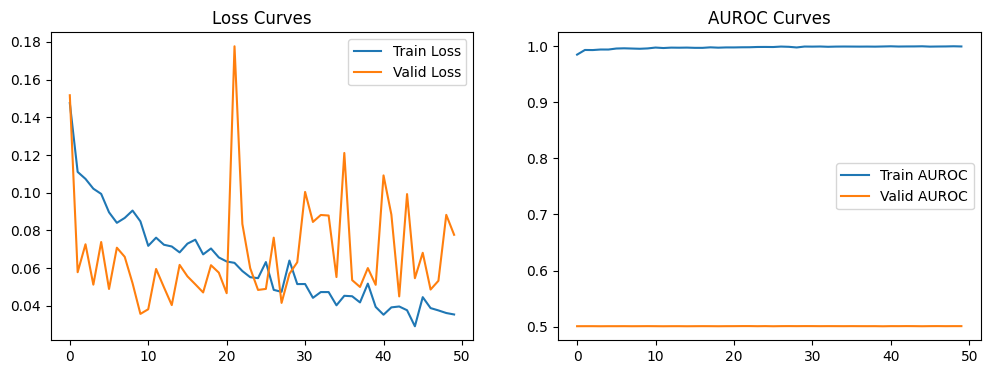

In [23]:
# Plot Loss and AUROC Curves
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['Train Loss'], label='Train Loss')
    ax1.plot(history['Valid Loss'], label='Valid Loss')
    ax1.set_title('Loss Curves')
    ax1.legend()

    ax2.plot(history['Train AUROC'], label='Train AUROC')
    ax2.plot(history['Valid AUROC'], label='Valid AUROC')
    ax2.set_title('AUROC Curves')
    ax2.legend()

    plt.show()
    
# Logs
plot_metrics(history)